# CS696 Project: SEIR Model 
# Author: Jeff Ahn 

Please read this article before viewing the code else you will be very lost!

This project is an implementation of the SEIR model in epidemiology. SEIR stands for
Susceptible, Exposed, Infected and Removed which refer to the possible states of an individual
during an epidemic and the states represented in this model. See https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology for more. The following is a long 
explanation of the model and it does get a little mathy.

Many simplifying assumptions are made.


# Intracell Spreading
Imagine a square grid and within each cell is its own contained population of N people.
We assume a pure heterogeneous mixing of these people. All people in this cell start in
the Susceptible (S) state. Next imagine some small proportion of these N people have been
exposed to a contagious disease. We will introduce the disease this way by choosing a 
single cell randomly and randomly choosing what proportion of this cell will be exposed to the 
disease. This gives us the initial Exposed (E) sub-population. Eventually the exposed people transition 
into the Infected (I) state. The
difference between Exposed and Infected is the incubation period. When a person contracts
a contagious disease there is often a delay between when they contract the disease
and when its symptoms come into full swing. This delay is known as the incubation period.
Then after some time the infected individuals will infect more people from the S state.
Next after some amount of time, the initial Infected people transition into the Removed (R) 
state. This time period is known as the
infectious period. The Removed state makes no distinction between recovered or dead. Eventually
all people in the S state will will move into E, then into I, then finally into R.

The intra- in intracell means 'within' and this portion of the model
describes how the full course of the disease is run within a single cell on a grid.

# The Equations

Let us now describe the equations used to model the rates at which the different states of
SEIR are reached.

Let $S(t), E(t), I(t), R(t)$ be the number of Susceptible, Exposed, Infected, and Removed at a 
given time $t$ respectively for some given cell and let $N$ be the sum of the 4 functions (always
constant at every t). Let $\beta$ be transmission rate per person per unit time then we
have our first differential equation, the Susceptible Equation (1):

\begin{equation}
  \frac{dS}{dt} = -\beta I(t) \frac{S(t)}{N}
\end{equation}

Assuming a purely heterogeneous population, an Infected person comes into contact 
with a Susceptible with probability
$\frac{S(t)}{N}$, then eq (1) describes the expected number of new infected
individuals at time $t$ which is equal to the rate at which $S(t)$ declines.

Next let $\alpha^{-1}$ be the incubation period, that is, the time it takes for a single
person to transition to an Infectious state after being exposed to the disease. This
implies $\alpha$ is the rate at which an exposed person moves to the infected state 
(another way to describe this state is when a person is symptomatic or able to cause 
secondary infections). Then we have the Exposed Eq (2)

\begin{equation}
  \frac{dE}{dt} = \beta I(t) \frac{S(t)}{N} - \alpha E(t)
\end{equation}

Note that the first term in the equation is the negative of equation (1).
This equation is describing the rate at which people enter the Exposed state 
(due to transmissions) and the rate that they leave it and
enter the Infected state (after waiting a full incubation period). 
The two terms are 'fighting' each other.

Next let $\gamma$ be the recovery rate per person per unit time ($\gamma^{-1}$ 
is the mean infectious period). Then the Infected Equation (3) is as follows:

\begin{equation}
  \frac{dI}{dt} = \alpha E(t) - \gamma I(t)
\end{equation}

Notice the first term is the last term of equation (2). The equation is describing
the rate at which people are entering the Infectious state (from Exposed state) and 
leaving it to the Removed state (after waiting the mean infectious period).

Lastly, we have the Recovery/Removed Equation: 

\begin{equation}
  \frac{dR}{dt} = \gamma I(t)
\end{equation}

Which says the rate of recovery is equal to the rate individuals are being
converted from Infected to Removed (the last term in previous equation).

It is helpful to think of each of the equations as a flow char. Imagine
four cylinders stacked on top of each other labeld, Susceptible, Exposed, Infected, 
and Removed respectively with water (people) contained only in the Susceptible cylinder 
at the start. Then a spout from S is opened and pours into E, and a spout in E is opened
which pours into I, and lastly into R. The SEIR equations describe the rate people 
are flowing from one bin to another. 

So for each time step (1 day) in the simulation, equations (1) - (4) are used 
to calculate the change in each of the three quantities in each cell
by using Euler's method of integration. Recall Euler's method, let $f$ be a scalar
valued function with independent variable t then:

\begin{equation}
    f(t+1) = f(t) + f'(t)\Delta t
\end{equation}

This is the equation used in code to compute the proportions of $S(t), E(t), I(t), R(t)$ at every
time step $\Delta t = 1$

Written in the code, the three quantities S, E, I, and R are stored in three separate grids and for any cell
${(i,j)}$, $S_{i,j} + E_{i,j}, I_{i,j} + R_{i,j} = N_{i,j}$ where $N_{i,j}$ is the total
size of the sub-population. Also note that the net flow rate must follow a zero-sum system ie:

\begin{equation*}
  \frac{dS}{dt} + \frac{dE}{dt} + \frac{dI}{dt} + \frac{dR}{dt}  = 0
\end{equation*}

Also, note that the equations do not factor in birth or natural mortality rate so $S(t)$ never increases
and $R(t)$ never decreases.

# Intercell Spreading

The above describes the disease spreading between people within a single cell, but what about 
between other cells? Surely the disease can spread between different neighborhoods, blocks, and counties
so how can we model mobility? Inter- in intercell spreading refers to how the 
the disease spreads between cells. Imagine for each cell a proportion of Infected state people 
are allowed to 'leave' its current cell and move other cells and spread the disease there. 
For each cell, the model chooses randomly 8 neighboring cells by using a 2D gaussian kernel. 
Imagine centering a small normalized gaussian kernel over a single cell and the height of the gaussian 
corresponding to the probability that neighboring cell is chosen. The cells closest to
the center, then, have a higher chance of being selected as a neighbor. This is how neighboring cells
are selected for each cell and this is how mobility is modeled.

The model uses the equations above to re-calculate new S,E,I,R populations using Euler's
method, but the only difference is a source-dest relationship for example between two 
cells $r,c$ the source and $dr,dc$ the destination:

\begin{equation}
    S_{dr,dc}(t+1) = S_{dr,dc}(t) + S'_{r,c}(t)\Delta t
\end{equation}

Which is saying when considering the neighboring cell's new susceptible population, use the center cell's susceptible rate of change.


# The Constants

We have not yet explained how the constants $\beta$, $\alpha$, and $\gamma$ 
(transmission rate, incubation rate, and recovery rate) are 
obtained for the model. For this particular assignment we are modeling COVID-19 and 
some of the values for the constants can be taken from various sources online or even estimated.

If $\alpha$ is the incubation rate (days$^{-1}$) then $\alpha^{-1}$ is the mean 
incubation period (days) which is the time between being exposed to a disease and 
showing symptoms or causing secondary infections. The incubation period for 
COVID-19 is taken to be anywhere between 2-14 days from various sources online with outliers
of up to 24 days. A value of 6.4 days was chosen as the incubation period for this assignment.
See https://www.worldometers.info/coronavirus/coronavirus-incubation-period/ for more.

If $\gamma$ is the recovery rate of a disease then $\gamma^{-1}$ is the mean infectious
 period that is, the time it takes to recover from the disease after showing symptoms. The
recovery rate of COVID-19 was taken to be 14 days from various sources and that is the value
chosen for this assignment.

The transmission rate $\beta$ is calculated based on yet another constant known in 
epidemiology called $R_0$. $R_0$ is the basic reproduction number which is the 
expected number of secondary infections caused by a single infected person. Then we have:

\begin{equation}
    R_0 = \beta \gamma^{-1}
\end{equation}

That is, the number of secondary infections is the transmission rate times the mean infectious period
(So the longer the infectious period the more secondary infections). At the time of this writing, various sources claim $R_0$ for COVID-19 is between 3.8-8.9 so the mean of these two was taken for this assignment. Then knowing
$R_0$ and $\gamma^{-1}$, we can solve for an approximate value for $\beta$. That is how $\beta$ is calculated
for this assignment as you will find in the code.

A table of $R_0$ values is listed here: https://en.wikipedia.org/wiki/Basic_reproduction_number. 


# Starting Population

Most metroplitan cities follow a 2D Gaussian distribution in their densities. Under the asssumption that the center of a city
(eg Manhattan) is the most dense, the density decreases as you walk outward from the center. So
each cell in the grid has a starting population that is proportional to the height of a normalized 2D Gaussian. In each cell in the grid we multiply the Total Expected population of the grid with $g(x,y)$ where $g$ is a normalized 2D Gaussian function and $(x,y)$ is the cell's x,y (or (row, col)) coordinate. This yields the actual total population for that cell. https://en.wikipedia.org/wiki/Gaussian_function. 

A single random cell is chosen as the starting exposed infection point and a (uniform) random function (0,1] is multiplied to it to determine the starting number of exposed people's for that cell. Then the simulation iterates day by day applying a round of intercell spreading (jumping around to other cells) and Euler's method of integration to compute new SEIR proportions.

This concludes the report, let's dive into the code. Please pay attention to the comments.

In [1]:
import numpy as np # computation
import matplotlib.pyplot as plt # plotting graphs
import seaborn as sb # for heatmaps
import gc # manual garbage collection to free up some memory during computation

In [2]:
# ALL CONSTANTS STORED IN THIS CELL

"""
DIMENSIONS of the grid. Try larger values if you want but, 
keep it square and note that the computation grows at a quadratic rate
"""
MAX_ROWS = 150
MAX_COLS = 150

"""
Max num of days to simulate 
"""
MAX_DAYS = 160

"""
S = Total Susceptible per cell i, j
E = Total Exposed per cell i, j
I = Total Infected per cell i, j
R = Total Removed per cell i, j
N = Total population per cell i, j (N[i][j] = S[i][j] + E[i][j] + I[i][j] + R[i][j])
"""
S, E, I, R, N = [], [], [], [], []

"""
Each cell will have a list of random Gaussian chosen neighbors
"""
mobility_matrix = []

"""
Total sum of all persons in every cell Sigma(N[r][c]) for all row, col.
This is used to multiply with the 2D Gaussian function to assign starting values
S(0) for each cell. 
"""
TOTAL_POPULATION = 1629000

"""
ALPHA - the incubation rate and 1/Alpha = incubation period. Values
chosen from this source:
https://www.worldometers.info/coronavirus/coronavirus-incubation-period/
"""
ALPHA = 1 / 6.4

"""
GAMMA - Recovery rate, estimated as 1/(mean infectious period). 
the number here is taken from https://en.wikipedia.org/wiki/Coronavirus_disease_2019#Prognosis
The mean infectious period is near 2 weeks. 
"""
GAMMA = 1.0 / 14

"""
R_nought - the basic reproduction number. The expected number of secondary
infections per infected person. This value for covid19 has high variance 
according wikipedia: https://en.wikipedia.org/wiki/Basic_reproduction_number
"""
R_0 = (3.8 + 8.9)/2

"""
BETA - Transmission rate in persons/time
the number was estimated from looking at global data for the number of daily cases
we take an average of the upper and lower bounds.
https://www.worldometers.info/coronavirus/coronavirus-cases/#daily-cases
"""
BETA = R_0 * GAMMA

"""
mu = mean to center the gaussian over the center of the grid
"""
mu = (MAX_ROWS/2 + MAX_COLS/2)/2

"""
sigma = std. dev. of gaussian for adjusting the width of the kernel
(must be large to get full spread over the grid)
"""
sigma = 40

In [3]:
# All equations are stored in this cell

"""
2d gaussian function
mu1 mu2 are the means for x and y axis (offset)
"""
def gaussian(row, col, mu1, mu2, std):
    return np.exp(-((col-mu2)**2 + (row-mu1)**2)/(2*std*std))

"""
1st order non-linear DiffEQs based on the SEIR model
variables s,e,i,r are the sus, expo. inf., remov. populations for a single cell
"""
def s_prime(s, i, n, beta):
    return -beta*i*s/n

def e_prime(s, e, i, n, beta):
    return beta*i*s/n - ALPHA*e

def i_prime(e, i):
    return ALPHA*e - GAMMA*i

def r_prime(i):
    return GAMMA*i

"""
Euler's method - Add to the current pop the rate of change times delta t = 1
"""
def s_euler(s, i, n, beta):
    return s + s_prime(s, i, n, beta)

def e_euler(s, e, i, n, beta):
    return e + e_prime(s, e, i, n, beta)

def i_euler(e, i):
    return  i + i_prime(e, i)

def r_euler(r, i):
    return r + r_prime(i)

"""
vectorizing a method will allow the method to be performed
on each cell of a matrix without having to write for loops
every time.
"""
vectorized_s = np.vectorize(s_euler)
vectorized_e = np.vectorize(e_euler)
vectorized_i = np.vectorize(i_euler)
vectorized_r = np.vectorize(r_euler)

# initializes populations
def init():
    BETA = R_0 * GAMMA
    
    s_temp = np.zeros((MAX_ROWS,MAX_COLS))
    e_temp = np.zeros((MAX_ROWS,MAX_COLS))
    i_temp = np.zeros((MAX_ROWS,MAX_COLS))
    r_temp = np.zeros((MAX_ROWS,MAX_COLS))
    n_temp = np.zeros((MAX_ROWS,MAX_COLS))
    
    # initialize the starting populations of each cell in N and S
    for r in range(MAX_ROWS):
        for c in range(MAX_COLS):
            n_temp[r][c] = gaussian(r, c, mu, mu, sigma)
            s_temp[r][c] = n_temp[r][c]
            
    # normalize the gaussian
    total = np.sum(n_temp)
    n_temp = np.divide(n_temp, total)
    s_temp = np.divide(s_temp, total)
    
    # multiply each cell by the expected population
    n_temp = np.multiply(n_temp, TOTAL_POPULATION)
    s_temp = np.multiply(s_temp, TOTAL_POPULATION)
    
    # create a list of 8 randomly chosen neighbors for each cell using a gaussian distribution
    mobility_matrix = [[Cell(r, c) for c in range(MAX_COLS)] for r in range(MAX_ROWS)]
            
    # random starting cell of infection 
    INFECTION_POINTS = [(int(np.random.random_sample() * MAX_ROWS), 
                    (int(np.random.random_sample() * MAX_COLS)))
                    for i in range(1)]    

    # Initialize exposed cells
    for p in INFECTION_POINTS:
        row, col = p[0], p[1]
        # randomly decide the proportion exposed, move them to exposed state
        init_infected = n_temp[row][col] * np.random.random_sample()
        e_temp[row][col] += init_infected
        s_temp[row][col] -= init_infected
    return s_temp, e_temp, i_temp, r_temp, n_temp, mobility_matrix

"""
Each cell creates a list of 8 neighbor cells 
selected randomly by a 2D gaussian distrib.
with a kernel much smaller than what was used
for the population grid.
"""
class Cell:
    def __init__(self, row, col):
        self._coord = (row, col)
        self.neighbors = self._get_neigh()
    
    def _get_neigh(self):
        r , c = self._coord[0], self._coord[1]
        neigh = []
        while len(neigh) < 8:
            dr = int(np.random.normal(r, 10))
            while dr < 0 or dr >= MAX_ROWS: 
                dr = int(np.random.normal(r, 10))
            dc = int(np.random.normal(c, 10))
            while dc < 0 or dc >= MAX_COLS: 
                dc = int(np.random.normal(c, 10))
            neigh.append((dr, dc))
        return neigh

In [4]:
# init all grids
S, E, I, R, N, mobility_matrix = init()

The following shows the initial state of the grid as a heatmap. It resembles a Gaussian as mentioned in the report. The higher intensity cells correspond to a higher population, N, for that cell.

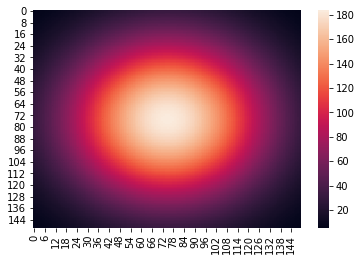

In [5]:
# display initial state total pop. distribution
sb.heatmap(N)
plt.show()

The following will display the initial infected cell that contains a random infected starting population.

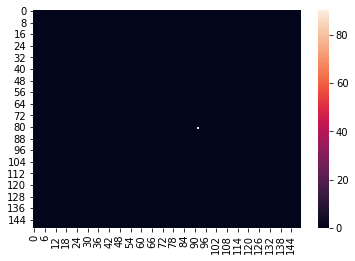

In [6]:
# display infected cells
sb.heatmap(E)
plt.show()

The following is a wrapper for the Intercell Spreading (or Gaussian) simulation. A lot of things are happening here. Starting from the top, it iterates once for each day. Within the loop, it copies the true values of S,E,I,R since they will be mutated within the loop. Using the copied values, we loop over each cell (r,c) in our grid and 'infects' its 8 neighbors (dr,dc) who were already determined 2 code blocks prior to this. Recall this equation from earlier:

\begin{equation}
    S_{dr,dc}(t+1) = S_{dr,dc}(t) + S'_{r,c}(t)\Delta t
\end{equation}

This is the intercell spreading step. The neighbor's new Susc. population will decrease and are converted into the Exposed state. The number of infected are divided by the number of neighbors (8) to account for proper weighting (not all infected persons move into a single neighboring cell).

Follwing that, is the intracell spreading step. Within each cell, a single round of Euler's method is applied to determine new quantities of S, E, I, R for that single cell. This is done using the vectorized methods (succinct).

At the bottom of the loop, cumulative sums of each state are taken for plotting later and also a snapshot of the heatmap will be taken every five days for displaying. The simulation will take ~1 minute at 150x150 cells.

In [7]:
def run(S,E,I,R,N):
    t = 0
    plot_total_s = []
    plot_total_e = []
    plot_total_i = []
    plot_total_r = []
    infected_heatmap = []
    while (t < MAX_DAYS and (np.sum(R)/TOTAL_POPULATION) < 0.97):
        # Continue until 97% removed has been reached OR max number of days simulated
        
        # Can't mutate original cells while simulating spreading
        S_temp = np.copy(S)
        E_temp = np.copy(E)
        I_temp = np.copy(I)
        R_temp = np.copy(R)

        for row in range(MAX_ROWS):
            for col in range(MAX_COLS):
                for neigh in mobility_matrix[row][col].neighbors:
                    dr, dc = neigh[0], neigh[1]
                    # convert the new infected neighbors from S state to E state
                    new_infected = s_prime(S[dr][dc], I[row][col]/8, N[dr][dc], BETA)
                    # can't have more than the TOTAL population or less than 0 people for each cell
                    S_temp[dr][dc] = max(0, S_temp[dr][dc] + new_infected)
                    E_temp[dr][dc] = min(N[dr][dc], E_temp[dr][dc] - new_infected)

        # Use Euler's method to determine new populations for current day
        S = vectorized_s(S_temp, I_temp, N, BETA)
        E = vectorized_e(S_temp, E_temp, I_temp, N, BETA)
        I = vectorized_i(E_temp, I_temp)
        R = vectorized_r(R_temp, I_temp)

        # add cumulative sums to the list
        plot_total_s.append(np.sum(S)/TOTAL_POPULATION)
        plot_total_e.append(np.sum(E)/TOTAL_POPULATION)
        plot_total_i.append(np.sum(I)/TOTAL_POPULATION)
        plot_total_r.append(np.sum(R)/TOTAL_POPULATION)

        if t % 5 == 0:
            infected_heatmap.append(I)

        gc.collect()
        t += 1
    return plot_total_s, plot_total_e, plot_total_i, plot_total_r, infected_heatmap

Here we run and plot the total S,E,I,R populations of every cell in the grid at every time step t.

In [8]:
# Takes a couple minutes for a 150x150 grid
plot_total_s, plot_total_e, plot_total_i, plot_total_r, infected_heatmap = run(S,E,I,R,N)

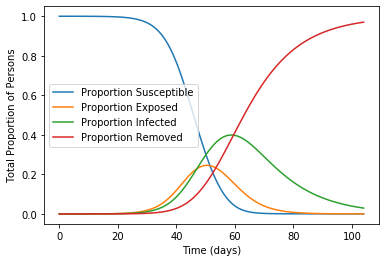

In [9]:
plt.plot([t for t in range(len(plot_total_s))], plot_total_s, label='Proportion Susceptible')
plt.plot([t for t in range(len(plot_total_e))], plot_total_e, label='Proportion Exposed')
plt.plot([t for t in range(len(plot_total_i))], plot_total_i, label='Proportion Infected')
plt.plot([t for t in range(len(plot_total_r))], plot_total_r, label='Proportion Removed')
plt.xlabel('Time (days)')
plt.ylabel('Total Proportion of Persons')
plt.legend()
plt.show()

Notice that the infected (and exposed) states are unimodal. This is because the exponential rate at which the disease spreads causes a spike in number of exposed (and then infected after the incubation period $\alpha^{-1}$) but begins to decline after infected persons begin to recover (or succumb) to the disease after the mean infectious period $\gamma ^{-1}$.

Below is shown a CDF (cumulative distribution function) of the total infected and removed states. This is expected since the Infected curve is approximately a normal one.

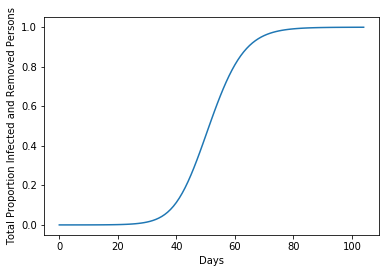

In [10]:
cum_quarantine = [plot_total_i[i] + plot_total_r[i] for i in range(len(plot_total_r))]
plt.plot([t for t in range(len(plot_total_r))], cum_quarantine)
plt.xlabel('Days')
plt.ylabel('Total Proportion Infected and Removed Persons')
plt.show()

Below will show the heatmaps of the Infected population that was recorded every 5 days during the simulation. A higher intensity corresponds to a higher number of people.

/home/jahn/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


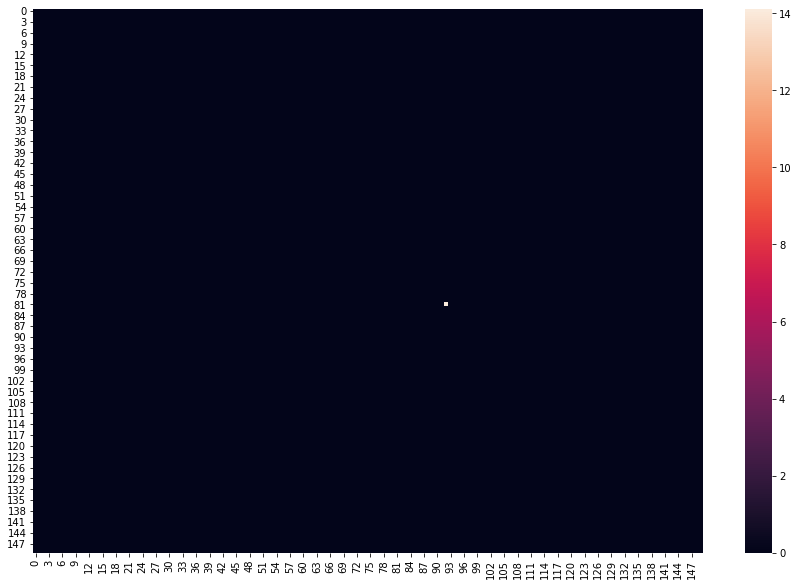

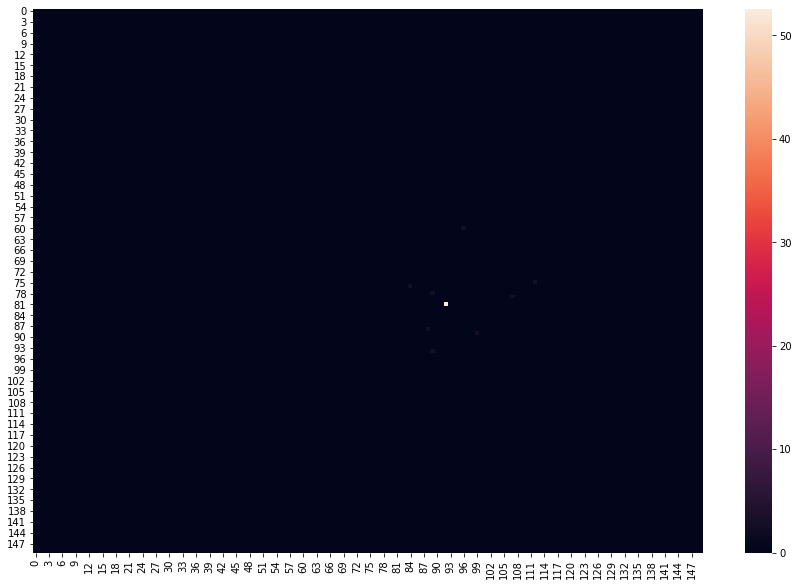

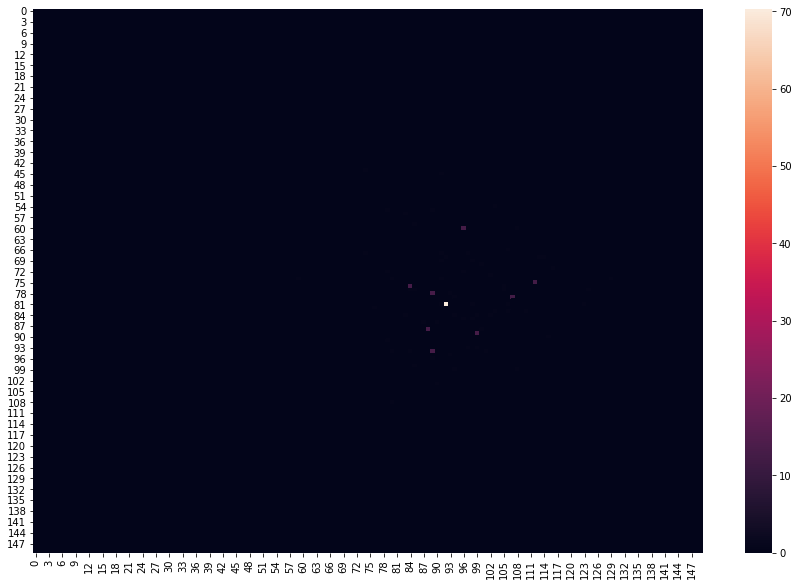

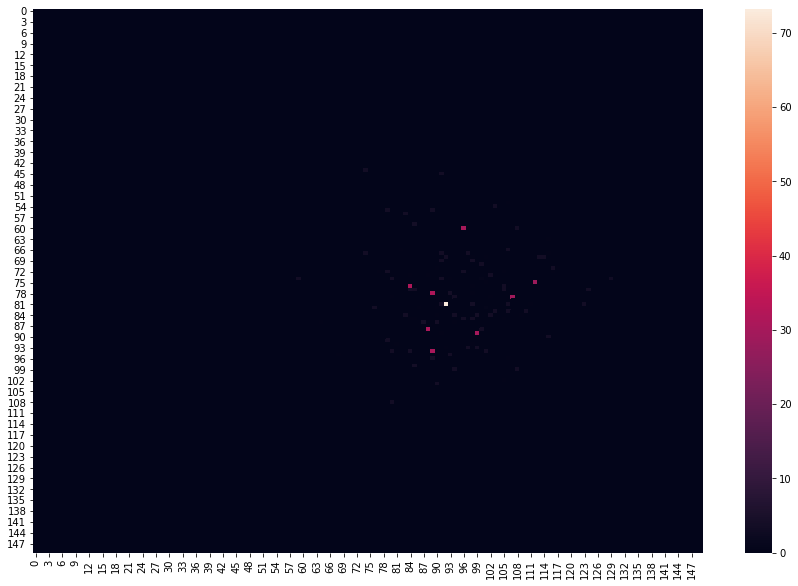

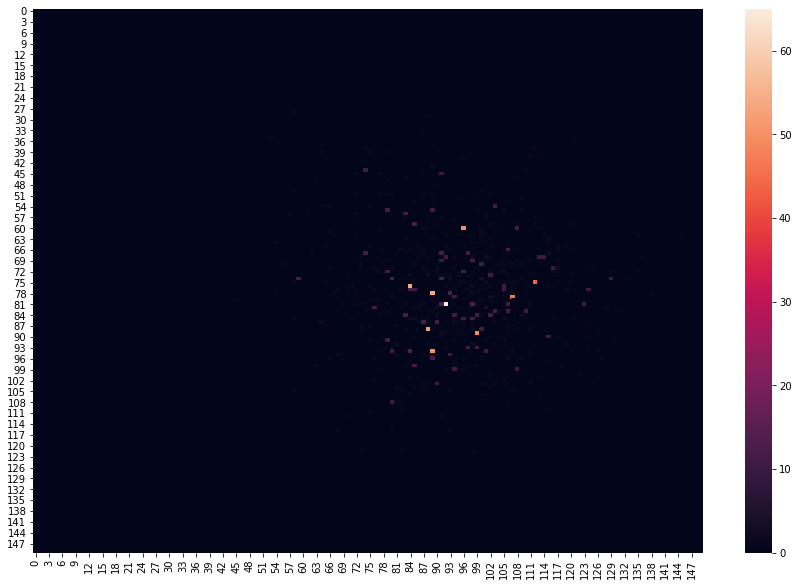

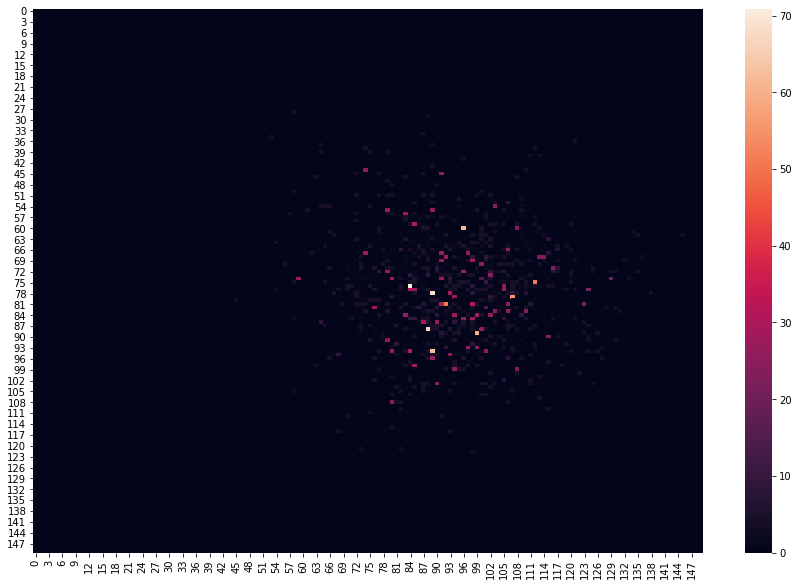

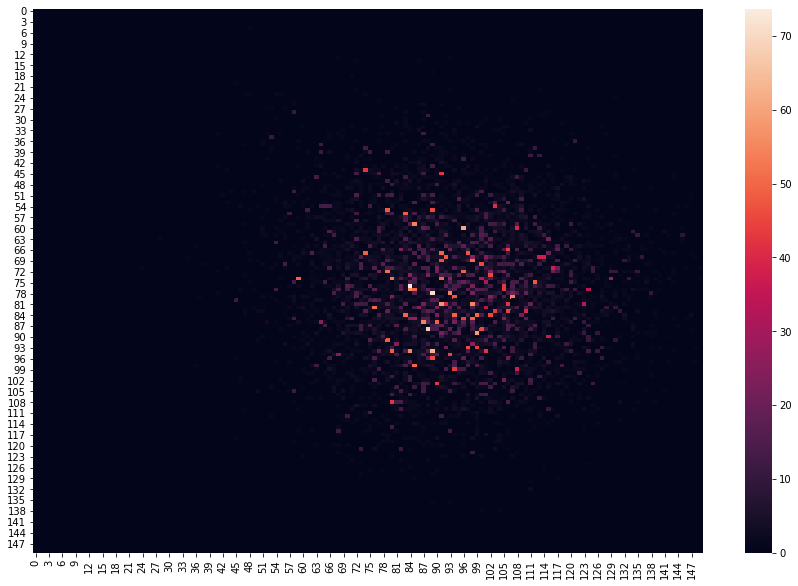

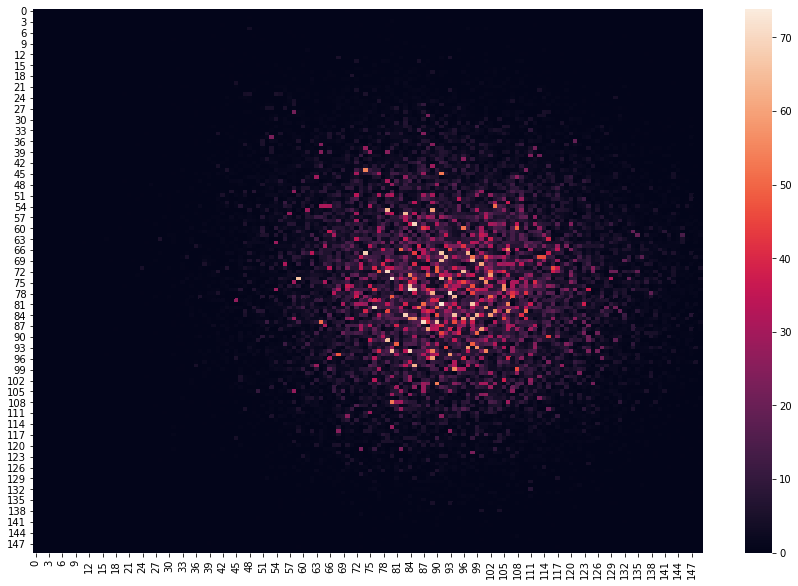

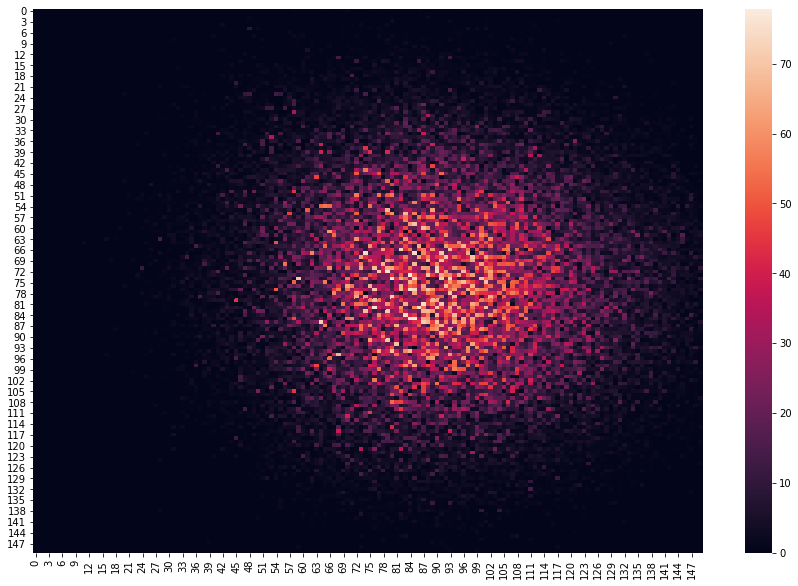

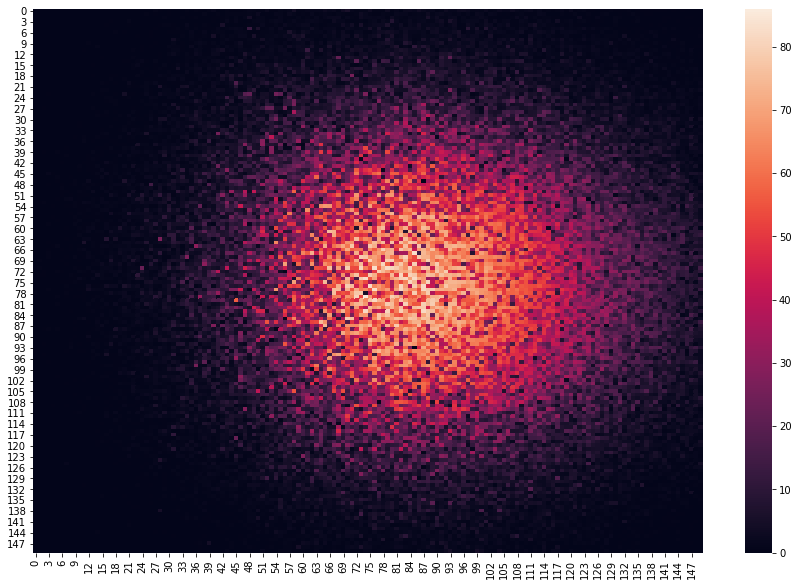

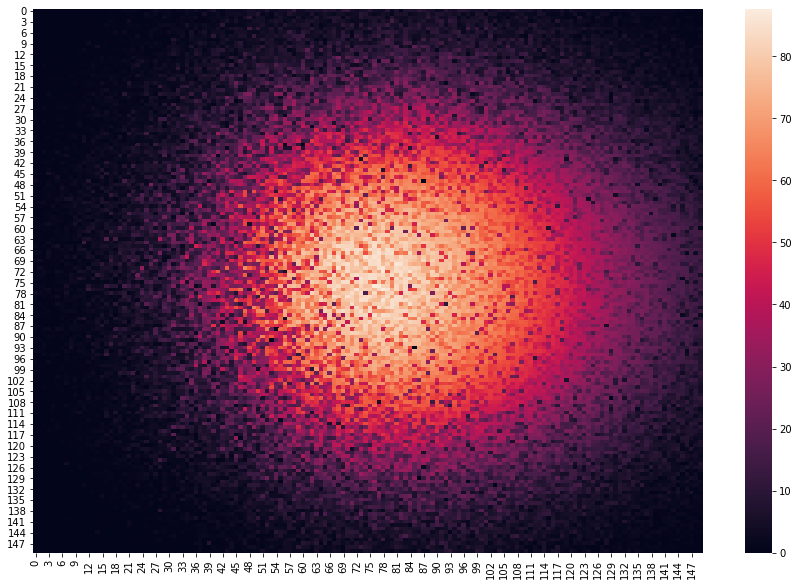

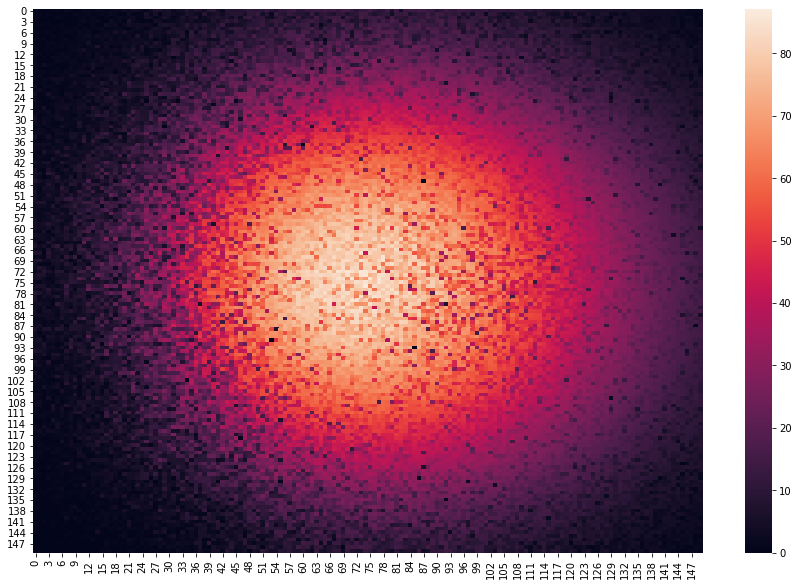

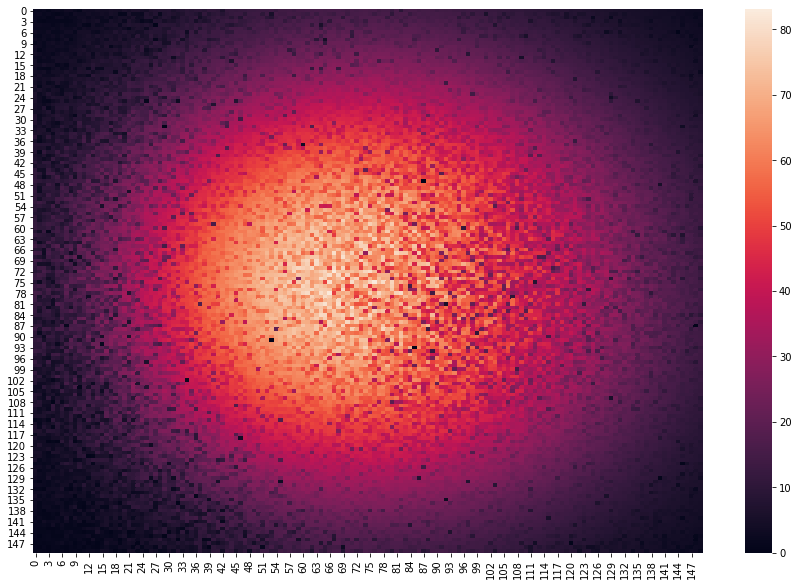

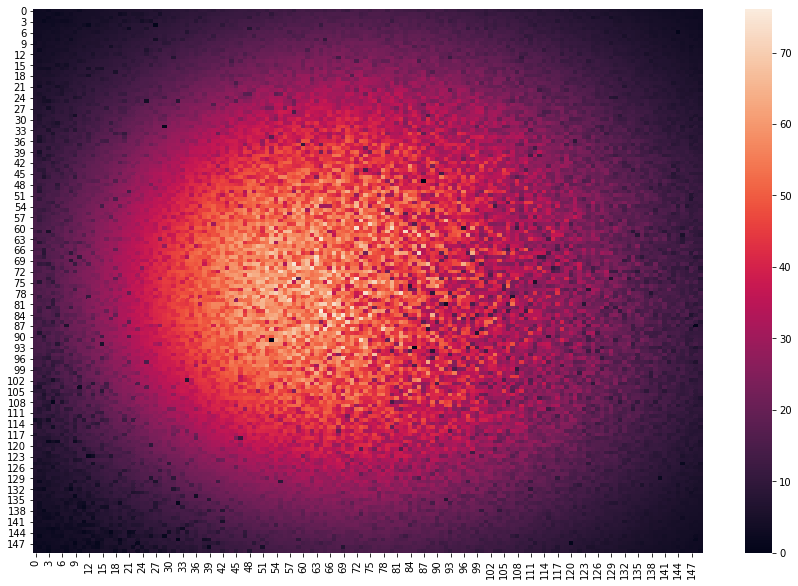

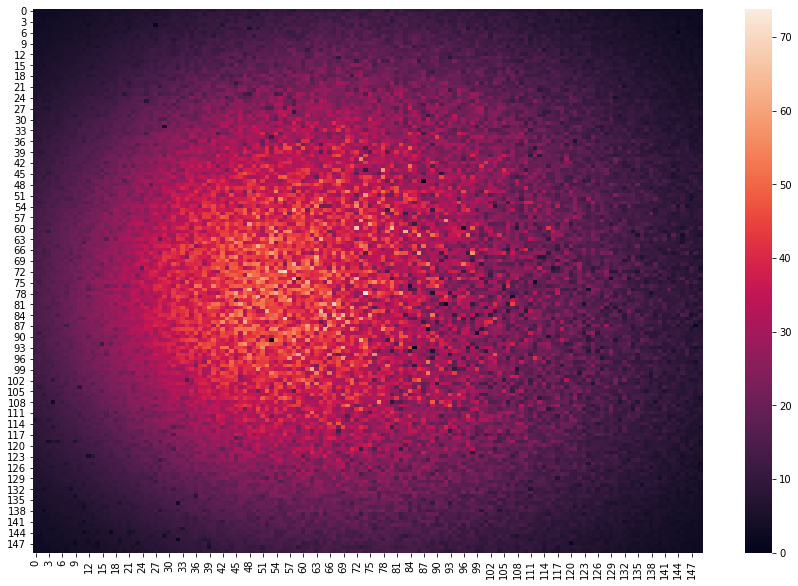

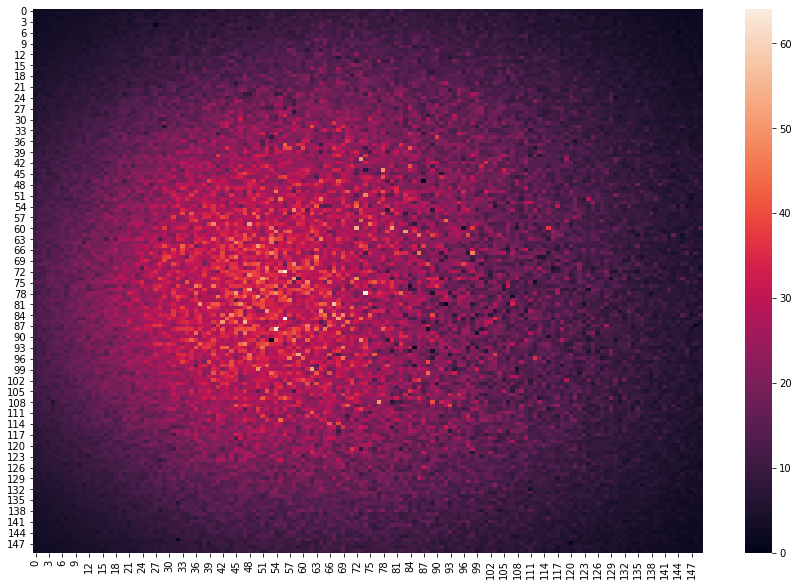

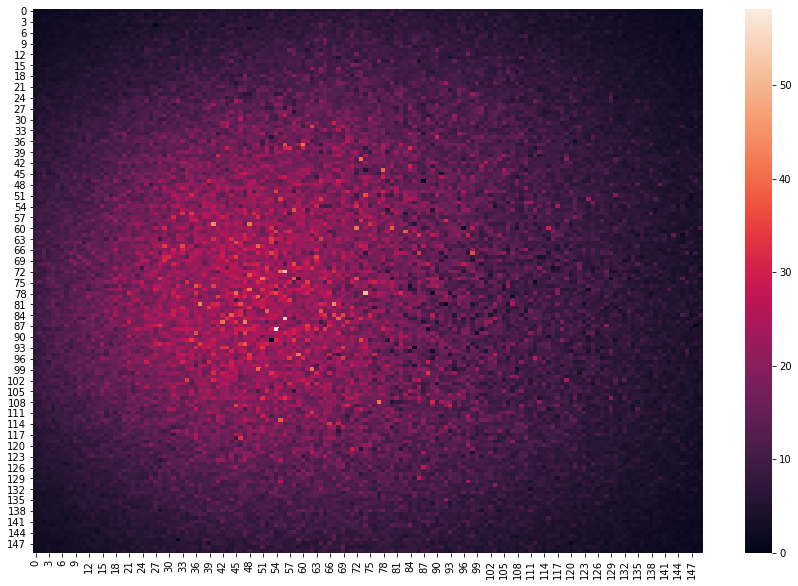

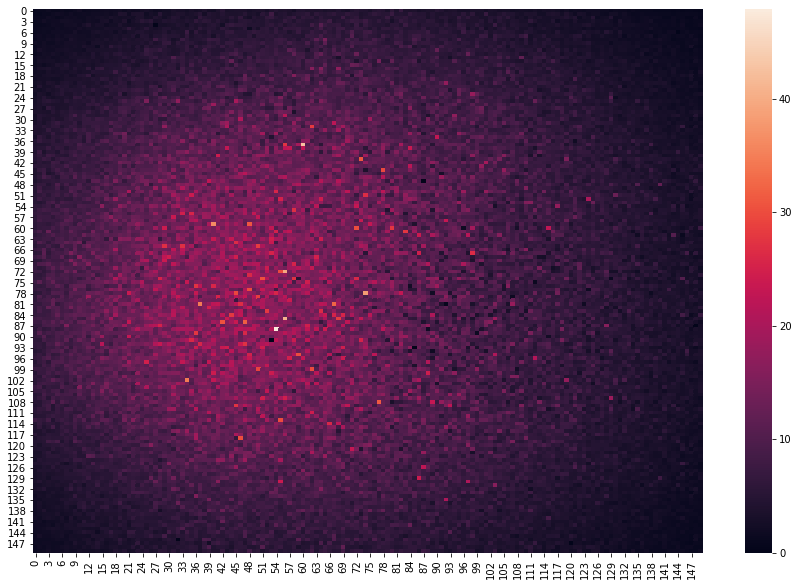

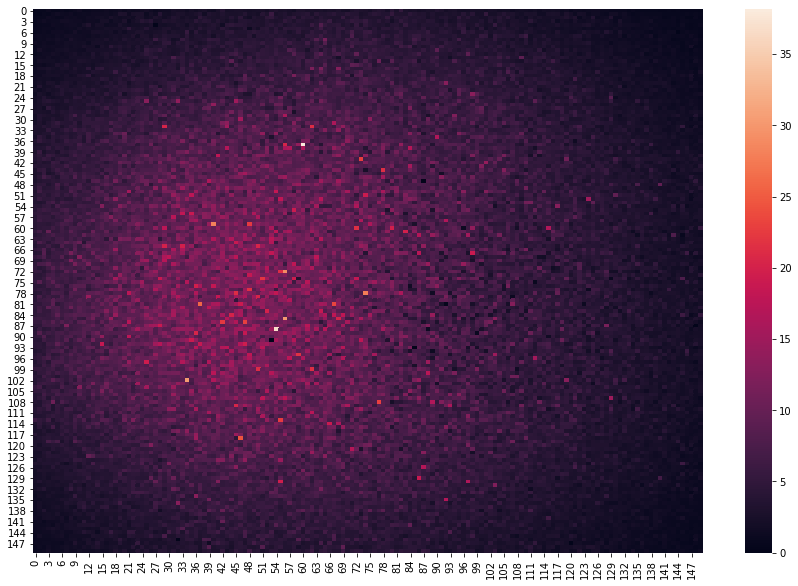

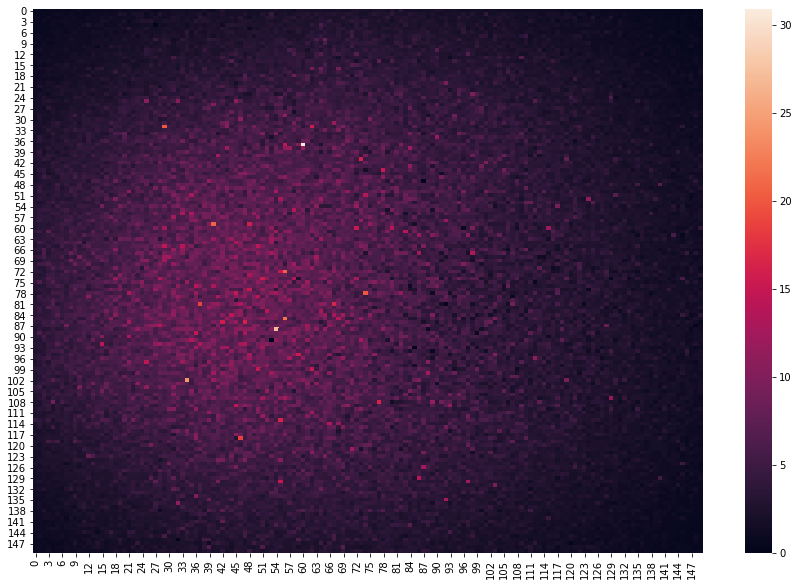

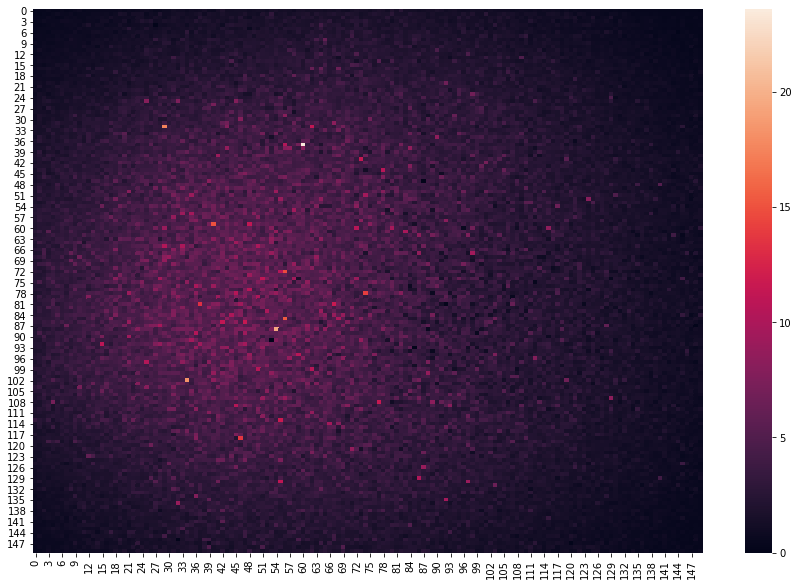

In [11]:
for i in range(len(infected_heatmap)):
    plt.figure(figsize=(15, 10))
    sb.heatmap(infected_heatmap[i])
plt.show()

A couple things to note is the exponential blowup of the number of infected. With each cell infecting 8 random neighbors (Gaussian), this is a $8^n$ in the fastest case where $n$ is the number of days.

The other thing is that the intensity of the once infected cells begins to wane towards the end of the simulation. This is because the Infected state is transitory one. Infected people that complete their infectious period, move into the next and terminal state, Removed. 

The previous model happens to be a huge overestimation of actual numbers. This model may only be accurate if no quarantine took place. We will re-run the model but this time with a $R_0$ that more closely resembles the current situation.  

Notice the much lower E,I,R proportions with this value of $R_0$. 

We can begin to estimate the accuracy of the model in the following way. 

1) Pick a city with readily available stats on COVID-19 and a high proportion of infected. I chose Manhattan. 

2) Find out the date of the first known case of COVID-19 for that city (March 1st for Manhattan).

3) Find the difference in the number of days between the first date and today and add the incubation period to find the total number of days that have elapsed since the first case's exposure in that city. 

4) Next run the model with Manhattan's total population. 

5) Find the elapsed day's plot point in ```plot_r[days]``` and ```plot_i[days]```. Add these two points (proportions) and multiply them with the city's (or district or county or whatever) total population and check if that number matches with the total number of cases for the city on this website: https://www.worldometers.info/coronavirus/country/us. 

At the time of this writing 73 days have elapsed since March 1st + 7 days (rounding up) for the mean incubation period. 

We also make two adjustments to the model. 

1) We have to find some compromise between using the higher pre-quarantine $R_0$ value and the lower post-quarantine $R_0$ value. At around March 20th, the mayor of New York City declares a shelter in place at home for all citizens.  We run the model again but we make the following changes to our ```run()``` method: Since the first recorded case of COVID-19 in New York was in Manhattan on March 1st, for the first 20 days, we use the higher value of $R_0$, then switch to the lower value after.

2) In post-quarantine, all mobility is reduced. When computing the number of new infected of a neighboring cell in the intercell step, we rescale the proportion of infected travelling into a neighboring cell.

In [12]:
def run2(S,E,I,R,N):
    t = 0
    plot_total_s = []
    plot_total_e = []
    plot_total_i = []
    plot_total_r = []
    infected_heatmap = []
    beta = BETA
    while (t < MAX_DAYS and (np.sum(R)/TOTAL_POPULATION) < 0.97):
        # Continue until 97% removed has been reached OR max number of days simulated
        
        """
        Switch to a new value of R_0 after 80 days to reflect quarantine.
        Recalculate the transmission rate (incubation and infectious period remain unchanged).
        Lastly, reduce the number of neighbors for each cell
        """
        if (t >= 20):
            r_0 = 1.2
            beta = r_0 * GAMMA
            
        # Can't mutate original cells while simulating spreading
        S_temp = np.copy(S)
        E_temp = np.copy(E)
        I_temp = np.copy(I)
        R_temp = np.copy(R)

        for row in range(MAX_ROWS):
            for col in range(MAX_COLS):
                for i in range(len(mobility_matrix[row][col].neighbors)):
                    """The idea here is, after the 20th day (quarantine) we limit 
                    the number of neighbors visited to just 3 instead of all 8 """
                    if t >= 20 and i > 3: 
                        break
                    neigh = mobility_matrix[row][col].neighbors[i]
                    dr, dc = neigh[0], neigh[1]
                    curr_infected_cell = I[row][col]
                    # convert the new infected neighbors from S state to E state
                    new_infected = s_prime(S[dr][dc], I[row][col]/8, N[dr][dc], beta)
                    # can't have more than the TOTAL population or less than 0 people for each cell
                    S_temp[dr][dc] = max(0, S_temp[dr][dc] + new_infected)
                    E_temp[dr][dc] = min(N[dr][dc], E_temp[dr][dc] - new_infected)

        # Use Euler's method to determine new populations for current day
        S = vectorized_s(S_temp, I_temp, N, beta)
        E = vectorized_e(S_temp, E_temp, I_temp, N, beta)
        I = vectorized_i(E_temp, I_temp)
        R = vectorized_r(R_temp, I_temp)

        # add cumulative sums to the list
        plot_total_s.append(np.sum(S)/TOTAL_POPULATION)
        plot_total_e.append(np.sum(E)/TOTAL_POPULATION)
        plot_total_i.append(np.sum(I)/TOTAL_POPULATION)
        plot_total_r.append(np.sum(R)/TOTAL_POPULATION)

        if t % 5 == 0:
            infected_heatmap.append(I)

        gc.collect()
        t += 1
    return plot_total_s, plot_total_e, plot_total_i, plot_total_r, infected_heatmap

In [13]:
# re-init all grids
S,E,I,R,N,mobility_matrix=init()

In [14]:
# run model again
plot_total_s, plot_total_e, plot_total_i, plot_total_r, infected_heatmap = run2(S, E, I, R, N)

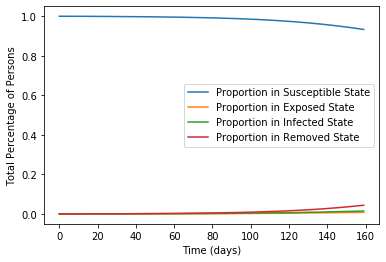

In [15]:
plt.plot([t for t in range(len(plot_total_s))], plot_total_s, label='Proportion in Susceptible State')
plt.plot([t for t in range(len(plot_total_e))], plot_total_e, label='Proportion in Exposed State')
plt.plot([t for t in range(len(plot_total_i))], plot_total_i, label='Proportion in Infected State')
plt.plot([t for t in range(len(plot_total_r))], plot_total_r, label='Proportion in Removed State')
plt.xlabel('Time (days)')
plt.ylabel('Total Percentage of Persons')
plt.legend()
plt.show()

Notice the much slower rate of convergence with smaller $R_0$. Next we calculate the experimental number of infected persons on the 73 + 7th day as mentioned earlier.

In [16]:
# number of cases by the 73rd day since March 1st (+7 to account for the incubation period)
TOTAL_POPULATION * (plot_total_r[73+7] + plot_total_i[73+7])

11264.286836627974

We can run the model multiple times and compute averages. The following sets a number of trials to run (~2 minutes per run) and an empty list to hold the outputs. This could take a long time depending on the number of trials set.

In [69]:
NUM_TRIALS = 10
TOTAL_CASES_LIST = []

In [70]:
for i in range(NUM_TRIALS):
    S,E,I,R,N,mobility_matrix=init()
    plot_total_s, plot_total_e, plot_total_i, plot_total_r, infected_heatmap = run2(S, E, I, R, N)
    TOTAL_CASES_LIST.append(plot_total_r[73+7] + plot_total_i[73+7])

Compute a mean and compare to the current number of total cases listed here: https://www.worldometers.info/coronavirus/usa/new-york/

In [71]:
lst = np.array(TOTAL_CASES_LIST)
lst.mean() * TOTAL_POPULATION

12568.025003369843

# Results

The total number of cases in the Manhattan borough up to today is 24,955. The number produced by the run I last made was around half that. So the model obviously has flaws and could use some adjustments such as using different number of neighbors for pre and post quarantine but then the model becomes susceptible (har-har) to overfitting.

# Conclusion

In this project I attempted to simulate a pandemic caused by COVID-19 at a city-wide level. This was done by using a square grid with a normally (Gaussian) distributed population and using the SEIR model to determine the rates of infection within each cell. SEIR stands for a susceptible, exposed, infected, and removed and refers to the 4 possible states in which a person can exist in the model. The SEIR mathematical model is a longstanding one that was invented in the 1920s during the influenza pandemic (see https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology). 

In addition, mobility was simulated by allowing each cell to infect randomly chosen neighbors also using a normal distribution. The model was then tuned to account for pre and post quarantine factors. In pre-quarantine the reproduction number $R_0$ is higher and then lowered after $x$ number of days. Pre-quarantine $R_0$ was found by taking a mean between a lower and upperbound estimate from sources online. The $x$ number of days was found by looking at online articles of when the first case of COVID-19 first occurred and when the city declared a shelter-in-place lockdown. The city chosen in this project was Manhattan, a burrough of NYC (the city which happens to have the highest number of cases in all of US) that has stats and data readily available online. Other constants and such as $\alpha$ (incubation rate), $\beta$ (transmission rate), and $\gamma$ (recovery rate) were calculated using similar methods and algebra. The SEIR is a set of first order differential equations, which were used to compute the new proportions of the S, E, I, and R states at every time step (days).

In the end, I would not consider this project a failure. Even though the numbers are off, the model produces data that does indeed resemble the typical exponential growth that one would expect from a pandemic. The heatmaps and the plots prove this. This assignment was a good one for theorizing a mathematical model then implementing into code and experimenting further. The model can be made more robust. There is no limit to how granular the model can be; only by what data is available to the data scientist.


# Further Reading

https://triplebyte.com/blog/modeling-infectious-diseases

https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30260-9/fulltext

https://www.worldometers.info/coronavirus/usa/new-york/